In [1]:
from google.colab import drive

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import json

In [4]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
cd /content/drive/MyDrive/pt_data/

/content/drive/MyDrive/pt_data


In [6]:
ls

aihub_annotations.json  best_model.pth         RDD2022/
AIhub_Road/             best_recall_model.pth  rdd2022_train_annotations.json


In [7]:
from torch.utils.data import Dataset, DataLoader
from typing import List, Dict, Any, Optional
import numpy as np
import torchvision.transforms as transforms

from PIL import Image

from IPython.display import display
from IPython import get_ipython

In [8]:
file_path = '/content/drive/MyDrive/pt_data/aihub_annotations.json'

with open(file_path, 'r', encoding='utf-8') as f:
    aihub_label = json.load(f)

print(type(aihub_label))

<class 'dict'>


In [9]:
folder_path = '/content/drive/MyDrive/pt_data/AIhub_Road'

data_list = []

for filename in os.listdir(folder_path):
    if filename.endswith('.pkl'):
        file_path = os.path.join(folder_path, filename)
        os.path.exists(file_path)

        with open(file_path, 'rb') as f:
            file_data = pickle.load(f)

            for one_data in file_data:
                data = {}
                data['image'] = one_data['image']
                if 1 in aihub_label[one_data['filename']]['labels']:
                  data['label'] = 1
                else:
                  data['label'] = 0

                data_list.append(data)

print(len(data_list))

<ipython-input-9-6ef1a8ab7a38>:11: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  file_data = pickle.load(f)


235846


In [10]:
file_path = '/content/drive/MyDrive/pt_data/rdd2022_train_annotations.json'

with open(file_path, 'r', encoding='utf-8') as f:
    rdd_label = json.load(f)

print(type(rdd_label))

<class 'dict'>


In [11]:
folder_path = '/content/drive/MyDrive/pt_data/RDD2022/'

for filename in os.listdir(folder_path):
    if filename.endswith('.pkl'):
        file_path = os.path.join(folder_path, filename)
        os.path.exists(file_path)

        with open(file_path, 'rb') as f:
            file_data = pickle.load(f)

            for one_data in file_data:
                data = {}
                data['image'] = one_data['image']
                if one_data['filename'] in aihub_label and not aihub_label[one_data['filename']]['labels']:
                  data['label'] = 0
                else:
                  data['label'] = 1

                data_list.append(data)

print(len(data_list))

<ipython-input-11-264253f96ea8>:9: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  file_data = pickle.load(f)


261324


In [12]:
X = []
y = []

for data in data_list:
    X.append(data['image'])
    y.append(data['label'])

print(len(X))
print(len(y))

261324
261324


In [13]:
!pip install wget torchinfo

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=d86bb24228f00474810fce0a5c214e6cc49f11634b889840664a3ea550fe8de0
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [14]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
from torch.cuda.amp import autocast, GradScaler
import numpy as np
from tqdm import tqdm
import seaborn as sns

import itertools
from torchinfo import summary
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import balanced_accuracy_score

In [15]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]    # numpy array, PIL.Image, Tensor 등 상관 없음
        label = self.y[idx]

        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    )
])

Training set size: 209059
Validation set size: 26132
Testing set size: 26133


In [17]:
train_data = MyDataset(X_train, y_train, transform=transform)  # 이미지면 transform 넣기
val_data = MyDataset(X_val, y_val, transform=transform)
test_data = MyDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True,
                          num_workers=4, pin_memory=True, persistent_workers=True)

val_loader = DataLoader(val_data, batch_size=32, shuffle=False,
                        num_workers=4, pin_memory=True, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=32, shuffle=False,
                         num_workers=4, pin_memory=True, persistent_workers=True)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 209059
Validation set size: 26132
Test set size: 26133


In [18]:
from torchvision import models

model = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 228MB/s]


In [19]:
model.fc = nn.Linear(model.fc.in_features, 1)

In [20]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 15
batch_size = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_recalls = []

In [22]:
from torch.cuda.amp import GradScaler

scaler = GradScaler()

<ipython-input-22-06055213f10c>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [23]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    scaler = GradScaler()  # AMP용 scaler

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        optimizer.zero_grad()

        # ✅ AMP 적용: 최신 PyTorch 방식
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # ✅ AMP backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # ✅ 예측 (outputs는 raw logits → sigmoid 필요 없음)
        preds = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [24]:
def evaluate(model, data_loader, criterion, device, phase="Validation", th=0.5):
    global best_val_recall
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, label in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), label.to(device)
            outputs = model(inputs)
            preds = (outputs > th).float()

            labels = labels.unsqueeze(1).float()
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            #_, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            # Save all labels and predictions for balanced accuracy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    recall = recall_score(all_labels, all_predictions)
    #precision = precision_score(all_labels, all_predictions)
    # balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    print(f"{phase} Recall: {recall:.2f}")
    if phase == "Validation":
        val_losses.append(epoch_loss)
        val_accuracies.append(accuracy)
        val_recalls.append(recall)
        if recall >= best_val_recall:
            best_val_recall = recall
            torch.save(model.state_dict(), "best_recall_model.pth")
            print("Best model saved!")

    if phase == "Test":
        f1_score_result = f1_score(all_labels, all_predictions)
        recall_score_result = recall_score(all_labels, all_predictions)
        precision_score_result = precision_score(all_labels, all_predictions)

        return f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions

    #return epoch_loss, accuracy
    #print(f"Balanced Accuracy: {balanced_acc:.4f}")

In [25]:
best_val_recall = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")

<ipython-input-23-94c254ac5358>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP용 scaler



Epoch 1/15


Training: 100%|██████████| 6534/6534 [02:17<00:00, 47.64it/s]


Train Loss: 0.2781, Train Accuracy: 87.65%


Validation: 100%|██████████| 817/817 [00:13<00:00, 60.36it/s]


Validation Loss: 0.2196, Validation Accuracy: 90.82%
Validation Recall: 0.90


<ipython-input-23-94c254ac5358>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP용 scaler


Best model saved!

Epoch 2/15


Training: 100%|██████████| 6534/6534 [02:10<00:00, 50.00it/s]


Train Loss: 0.1947, Train Accuracy: 91.80%


Validation: 100%|██████████| 817/817 [00:10<00:00, 75.93it/s]
<ipython-input-23-94c254ac5358>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP용 scaler


Validation Loss: 0.1951, Validation Accuracy: 92.45%
Validation Recall: 0.94
Best model saved!

Epoch 3/15


Training: 100%|██████████| 6534/6534 [02:10<00:00, 50.18it/s]


Train Loss: 0.1524, Train Accuracy: 93.63%


Validation: 100%|██████████| 817/817 [00:10<00:00, 76.23it/s]
<ipython-input-23-94c254ac5358>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP용 scaler


Validation Loss: 0.1921, Validation Accuracy: 91.93%
Validation Recall: 0.89

Epoch 4/15


Training: 100%|██████████| 6534/6534 [02:10<00:00, 50.01it/s]


Train Loss: 0.1199, Train Accuracy: 95.07%


Validation: 100%|██████████| 817/817 [00:10<00:00, 75.82it/s]
<ipython-input-23-94c254ac5358>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP용 scaler


Validation Loss: 0.1594, Validation Accuracy: 93.69%
Validation Recall: 0.93

Epoch 5/15


Training: 100%|██████████| 6534/6534 [02:10<00:00, 50.15it/s]


Train Loss: 0.0932, Train Accuracy: 96.20%


Validation: 100%|██████████| 817/817 [00:10<00:00, 75.27it/s]
<ipython-input-23-94c254ac5358>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP용 scaler


Validation Loss: 0.1704, Validation Accuracy: 93.88%
Validation Recall: 0.94

Epoch 6/15


Training: 100%|██████████| 6534/6534 [02:09<00:00, 50.40it/s]


Train Loss: 0.0745, Train Accuracy: 97.01%


Validation: 100%|██████████| 817/817 [00:10<00:00, 74.72it/s]
<ipython-input-23-94c254ac5358>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP용 scaler


Validation Loss: 0.1964, Validation Accuracy: 93.44%
Validation Recall: 0.93

Epoch 7/15


Training: 100%|██████████| 6534/6534 [02:08<00:00, 50.69it/s]


Train Loss: 0.0614, Train Accuracy: 97.55%


Validation: 100%|██████████| 817/817 [00:10<00:00, 76.04it/s]


Validation Loss: 0.1944, Validation Accuracy: 93.77%
Validation Recall: 0.94


<ipython-input-23-94c254ac5358>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP용 scaler


Best model saved!

Epoch 8/15


Training: 100%|██████████| 6534/6534 [02:09<00:00, 50.36it/s]


Train Loss: 0.0539, Train Accuracy: 97.90%


Validation: 100%|██████████| 817/817 [00:10<00:00, 74.55it/s]
<ipython-input-23-94c254ac5358>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP용 scaler


Validation Loss: 0.1942, Validation Accuracy: 93.67%
Validation Recall: 0.93

Epoch 9/15


Training: 100%|██████████| 6534/6534 [02:08<00:00, 50.68it/s]


Train Loss: 0.0470, Train Accuracy: 98.13%


Validation: 100%|██████████| 817/817 [00:10<00:00, 75.78it/s]
<ipython-input-23-94c254ac5358>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP용 scaler


Validation Loss: 0.2000, Validation Accuracy: 93.95%
Validation Recall: 0.94
Best model saved!

Epoch 10/15


Training: 100%|██████████| 6534/6534 [02:11<00:00, 49.79it/s]


Train Loss: 0.0420, Train Accuracy: 98.37%


Validation: 100%|██████████| 817/817 [00:10<00:00, 75.39it/s]
<ipython-input-23-94c254ac5358>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP용 scaler


Validation Loss: 0.2055, Validation Accuracy: 94.17%
Validation Recall: 0.95
Best model saved!

Epoch 11/15


Training: 100%|██████████| 6534/6534 [02:09<00:00, 50.30it/s]


Train Loss: 0.0381, Train Accuracy: 98.56%


Validation: 100%|██████████| 817/817 [00:10<00:00, 74.77it/s]
<ipython-input-23-94c254ac5358>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP용 scaler


Validation Loss: 0.2389, Validation Accuracy: 93.73%
Validation Recall: 0.94

Epoch 12/15


Training: 100%|██████████| 6534/6534 [02:08<00:00, 50.70it/s]


Train Loss: 0.0346, Train Accuracy: 98.68%


Validation: 100%|██████████| 817/817 [00:10<00:00, 75.44it/s]
<ipython-input-23-94c254ac5358>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP용 scaler


Validation Loss: 0.2481, Validation Accuracy: 93.66%
Validation Recall: 0.94

Epoch 13/15


Training: 100%|██████████| 6534/6534 [02:10<00:00, 50.03it/s]


Train Loss: 0.0320, Train Accuracy: 98.77%


Validation: 100%|██████████| 817/817 [00:10<00:00, 76.15it/s]
<ipython-input-23-94c254ac5358>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP용 scaler


Validation Loss: 0.2255, Validation Accuracy: 93.77%
Validation Recall: 0.94

Epoch 14/15


Training: 100%|██████████| 6534/6534 [02:09<00:00, 50.57it/s]


Train Loss: 0.0306, Train Accuracy: 98.82%


Validation: 100%|██████████| 817/817 [00:10<00:00, 74.89it/s]
<ipython-input-23-94c254ac5358>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP용 scaler


Validation Loss: 0.2202, Validation Accuracy: 93.90%
Validation Recall: 0.94

Epoch 15/15


Training: 100%|██████████| 6534/6534 [02:09<00:00, 50.27it/s]


Train Loss: 0.0286, Train Accuracy: 98.90%


Validation: 100%|██████████| 817/817 [00:10<00:00, 76.45it/s]


Validation Loss: 0.2527, Validation Accuracy: 94.35%
Validation Recall: 0.95


In [26]:
model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)
f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions = evaluate(model, test_loader, criterion, device, phase="Test")

Test: 100%|██████████| 817/817 [00:13<00:00, 58.98it/s]


Test Loss: 0.1985, Test Accuracy: 93.34%
Test Recall: 0.94


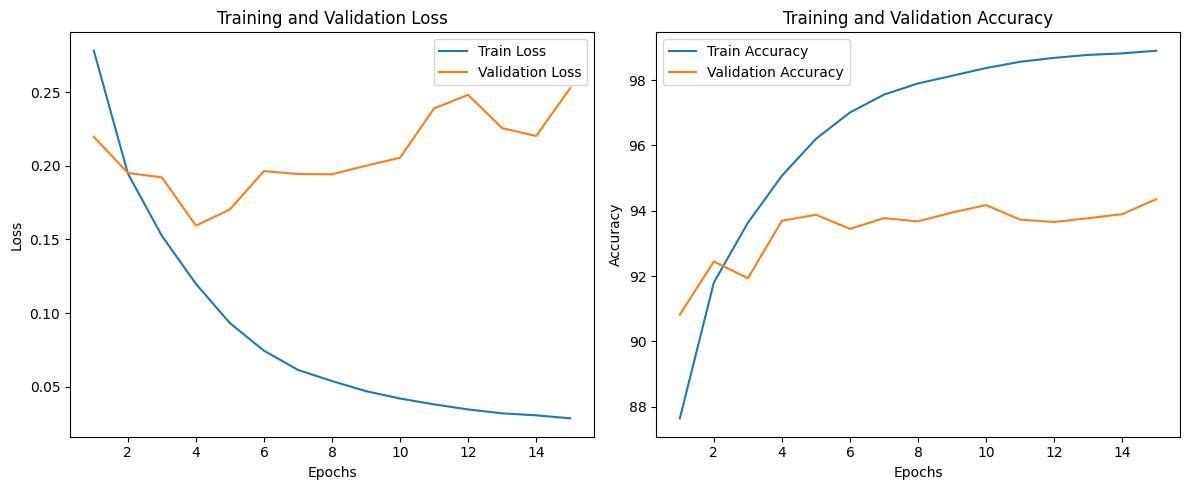

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss}
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions = evaluate(model, test_loader, criterion, device, phase="Test", th=0.1)

Test: 100%|██████████| 817/817 [00:10<00:00, 76.00it/s]


Test Loss: 0.1985, Test Accuracy: 93.25%
Test Recall: 0.95


In [29]:
print(f"F1 Score: {f1_score_result:.3f}")
print(f"Recall Score: {recall_score_result:.3f}")
print(f"Precision Score: {precision_score_result:.3f}")

F1 Score: 0.943
Recall Score: 0.951
Precision Score: 0.935


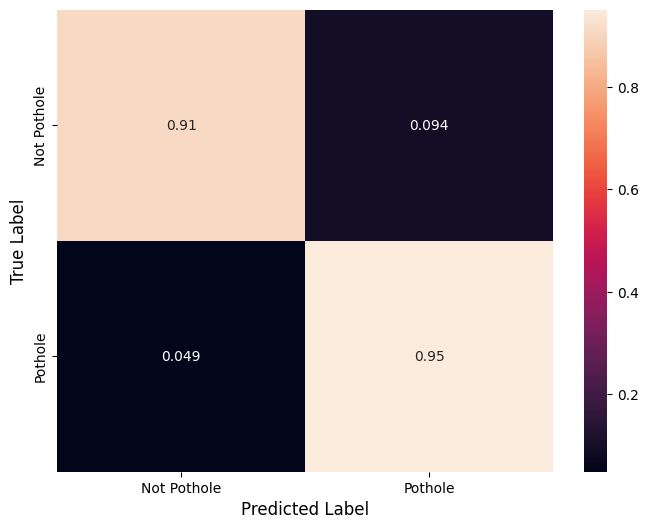

In [30]:
P_NP = ["Not Pothole", "Pothole"]

cf_matrix = confusion_matrix(all_labels, all_predictions)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in P_NP],
                     columns = [i for i in P_NP])

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

plt.show()

In [31]:
print(cf_matrix)

[[ 9742  1011]
 [  754 14626]]
